# Anticipez les besoins en consommation de bâtiments :
## Partie I : Nettoyage et analyse exploratoire

## Objectif : 
Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse à la consommation et aux émissions des bâtiments non destinés à l’habitation. À partir des relevés déjà réalisés, nous souhaitons prédire les émissions de CO2 et la consommation totale d’énergie.

## Ressources

La source de données est téléchargeable depuis ce lien :
https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv

Les informations relativs à la compréhension du dataset se trouvent ici:
https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

# 1. Lancement

## 1.1 Initialisation

In [1]:
# librairies de base
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from collections import Counter
import re
import os
pd.options.mode.chained_assignment = None
import warnings
import statistics
warnings.filterwarnings('ignore')
from haversine import haversine, Unit

In [2]:
# librairies de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier

In [3]:
# librairies de dataviz
import seaborn as sns
import missingno as msno
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import matplotlib.path as path
import geopy.distance

In [4]:
# Option d'affichage
pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)

In [5]:
# Chargement des données
data = pd.read_csv('building_energy.csv')

In [6]:
# catégorielle
cat = []
# numérique
num = []

for col in data.columns:
    if data[col].dtype == 'object':
        cat.append(col)
    else:
        num.append(col)

## 1.2 Overview

In [7]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


<AxesSubplot:>

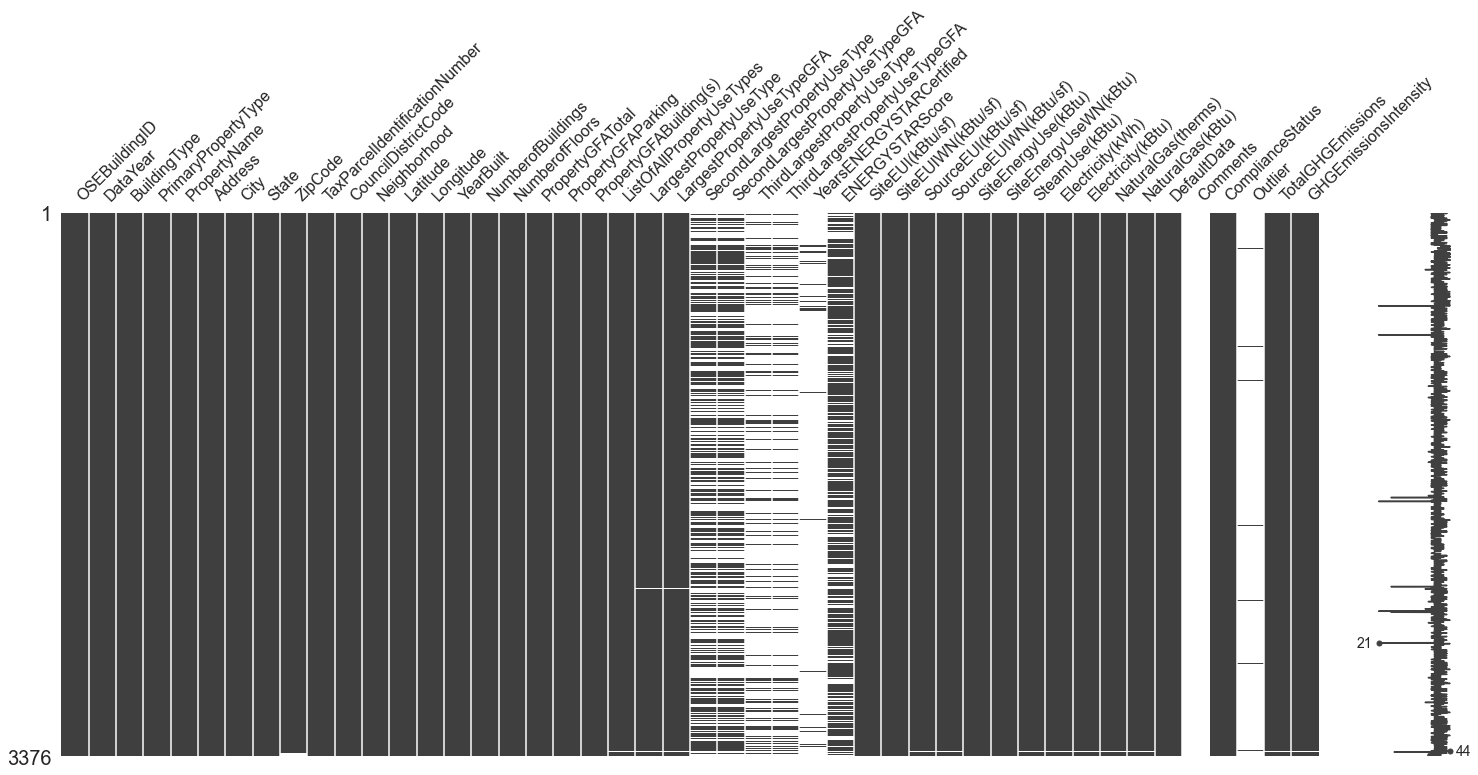

In [8]:
msno.matrix(data)

In [9]:
# Compter le nombre de valeurs remplies pour chaque colonne
data.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

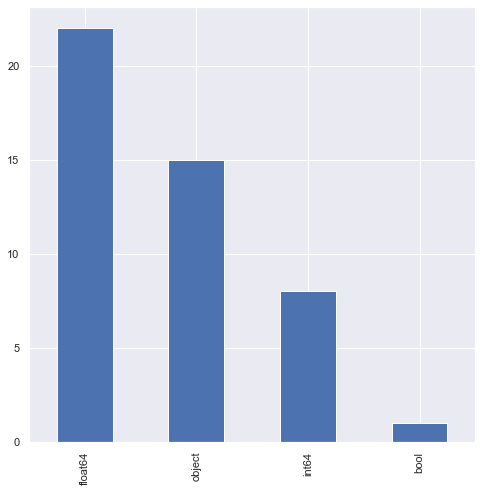

In [10]:
# Répartition des variables selon leur type
plt.figure(figsize=(8,8))
data.dtypes.value_counts().plot.bar()
plt.show()

In [11]:
# Vérifier si ce sont uniquement des données provenant de Seattle
for col in data.columns:
    if len(data[col].unique()) == 1:
        data = data.drop([col],axis=1)

# 2. Nettoyage

## 2.1 Nettoyage générique

In [12]:
# Vérification des index dupliqués
data.loc[data['OSEBuildingID'].duplicated(keep=False),:]
data = data.drop(['OSEBuildingID'],axis=1)
# data = data.drop_duplicates(subset=['OSEBuildingID'])

In [13]:
# Uniformiser le nom des quartiers
data.Neighborhood = data.Neighborhood.str.title()
data.Neighborhood = data.Neighborhood.str.replace(" Neighborhoods","")

In [14]:
# Transformer en NaN les others dans les 3 LargestPropertyUseType
LargestPropertyUseType = data.columns[(data.columns.str.contains("LargestPropertyUseType") == True) & (data.columns.str.contains('GFA') == False)].tolist()

In [15]:
# Enlever les bâtiments résidentiels
data = data[(data.BuildingType == 'NonResidential') | (data.BuildingType == 'NonResidential COS') | (data.BuildingType == 'Campus') | (data.BuildingType == 'SPS-District K-12') | (data.BuildingType == 'Nonresidential WA')]

<AxesSubplot:>

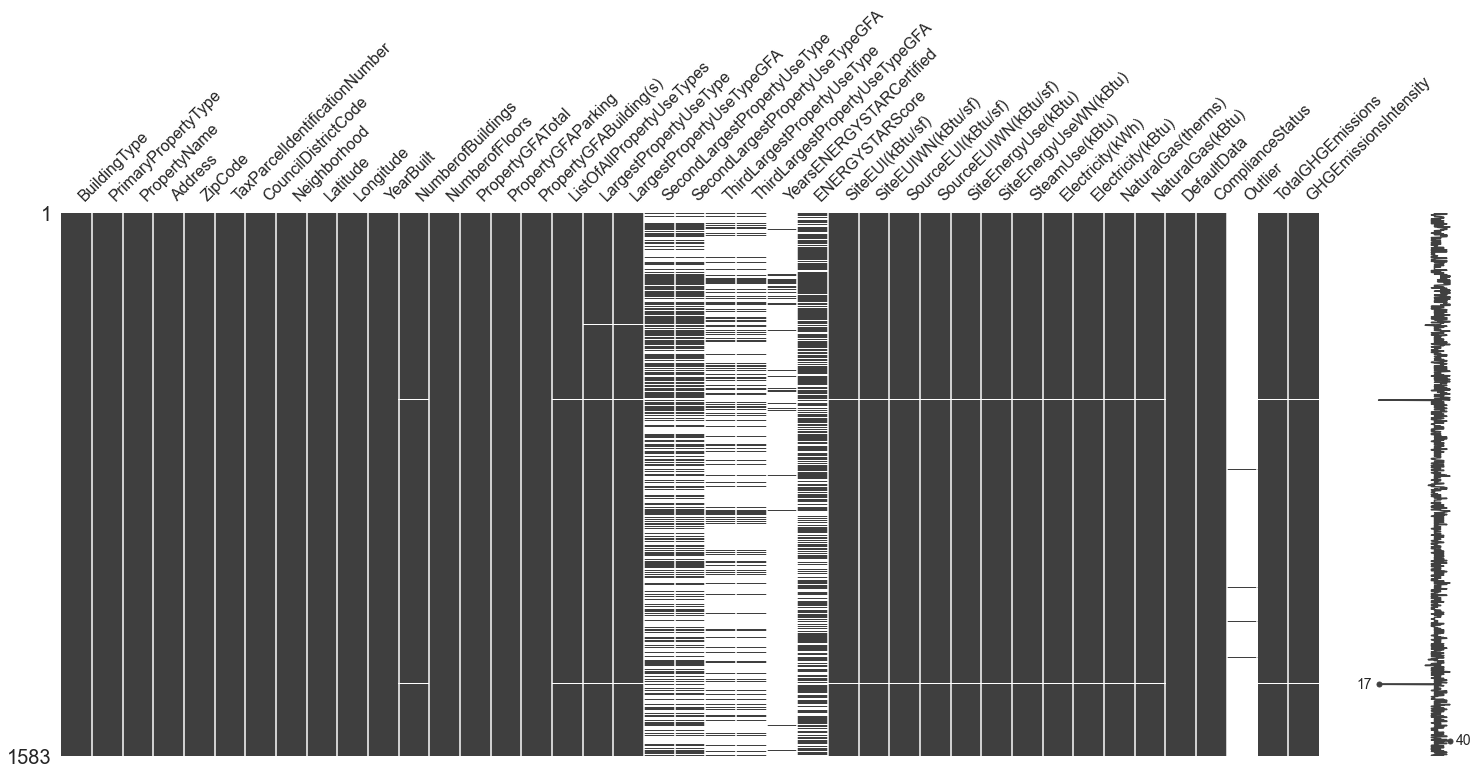

In [16]:
msno.matrix(data)

## 2.2 Traitement des valeurs abérrantes

In [17]:
# Suppression des propriétés ayant des caractéristiques abérrantes
high_outliers = data[data['Outlier'] == "High outlier"].index
data = data.drop(index = high_outliers).drop(['Outlier','DefaultData'],axis=1)

In [18]:
compliant = data.ComplianceStatus[data.ComplianceStatus == 'Compliant'].index
data = data[data.index.isin(compliant)].drop(['ComplianceStatus'],axis=1)

In [19]:
from sklearn.neighbors import KDTree

for column in data.select_dtypes(include = ['int32','float64']).columns.tolist() :
    "outliers aux extrémités des distributions"
    data.loc[data[column] > data[column].quantile(0.995)] = np.nan
    data.loc[data[column] < data[column].quantile(0.005)] = np.nan
print(data.shape)
    
#outliers éloignés par rapport à leurs voisins
numeric_data = data.select_dtypes(['int32', 'float64']).copy().dropna()
print(numeric_data.shape)
kdt = KDTree(numeric_data, leaf_size = 40, metric='minkowski')

dist, ind = kdt.query(numeric_data, k=3, return_distance=True)
numeric_data['3N_distance'] = np.sum(dist, axis=1)    
numeric_data = numeric_data[numeric_data['3N_distance'] < numeric_data['3N_distance'].quantile(0.99)]
index_to_drop = numeric_data.index.tolist()

data = data.drop(index_to_drop, axis=0)

(1467, 38)
(122, 27)


In [20]:
# Enlever les valeurs negatives
data['PropertyGFABuilding(s)'] = np.where((data['PropertyGFABuilding(s)'] < 0), np.nan,data['PropertyGFABuilding(s)'])

In [21]:
data = data.dropna(how='all')

<AxesSubplot:>

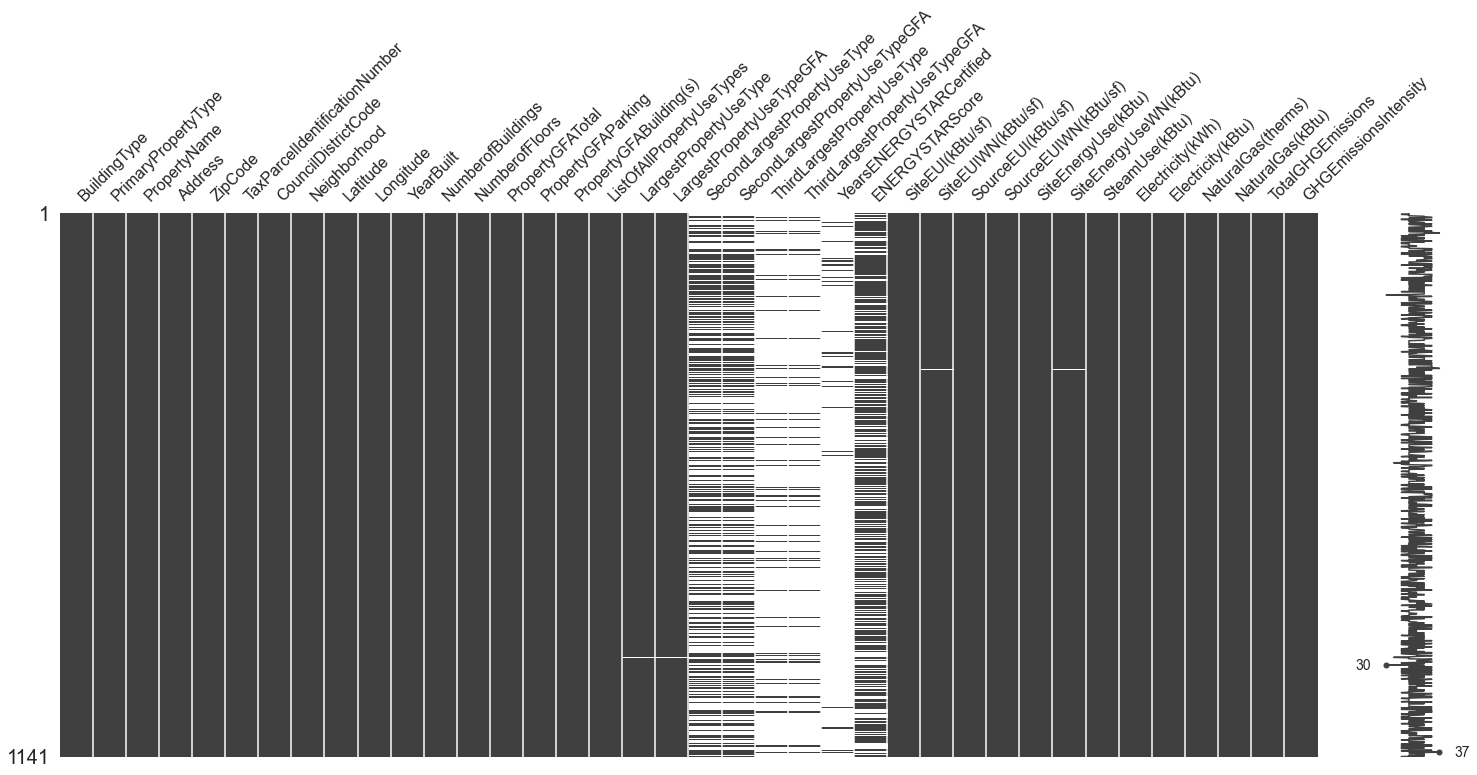

In [22]:
msno.matrix(data)

Selon Wikipedia :
- https://en.wikipedia.org/wiki/List_of_tallest_buildings_in_Seattle

Le bâtiment le plus haut de Seattle fait 76 étages.

In [23]:
#On exclue les bâtiments plus grands que ce qu'il est possible d'avoir car nous ne connaissons pas la vraie valeur
data = data[data['NumberofFloors'] < 76]

In [24]:
# Le nombre de bâtiment ne peut pas être égal à 0
# Enlever directement les val abérrantes
data['NumberofBuildings'] = data['NumberofBuildings'].replace([0.0],1.0)
data['NumberofFloors'] = data['NumberofFloors'].replace([0.0],1.0)

## 2.3 Feature engineering

In [25]:
# Proportion de surface non-parking
data['GFABuildingRate'] = (round((data['PropertyGFABuilding(s)'].fillna(0)
                                      /data['PropertyGFATotal'].fillna(0)),5))*100

In [26]:
# Distance par rapport au centre
downtown = (47.608056,-122.336111)
data['CBD_distance_km'] = data.apply(lambda x: haversine((x['Latitude'], x['Longitude']),downtown), axis=1)

In [27]:
# Surface par étage par bâtiment
data['Mean_GFA'] = data['PropertyGFATotal']/(data['NumberofFloors']*data['NumberofBuildings']).round(2)

In [28]:
# Âge de la construction
data['Age'] = 2016 - data['YearBuilt']

In [29]:
# Décoreller les variables liées aux sources d'energie
data['NaturalGasRate'] = round(data['NaturalGas(kBtu)']/data['SiteEnergyUse(kBtu)']*100,2)
data['ElectricityRate'] = round(data['Electricity(kBtu)']/data['SiteEnergyUse(kBtu)']*100,2)
data['SteamUseRate'] = round(data['SteamUse(kBtu)']/data['SiteEnergyUse(kBtu)']*100,2)

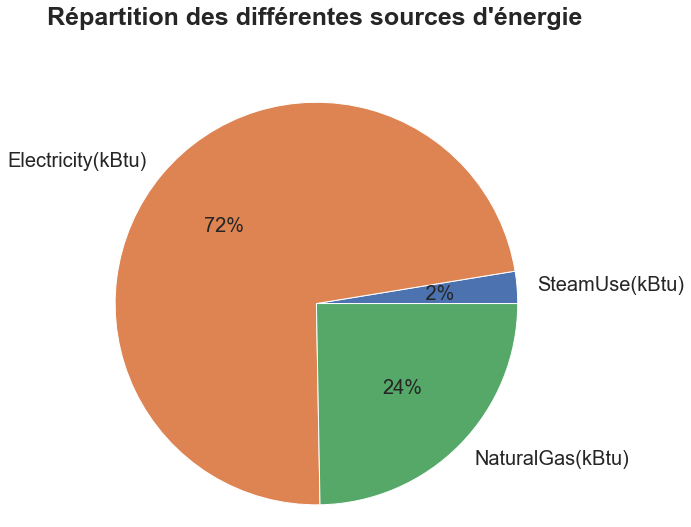

In [30]:
def plotPieChart(data, long, larg, title):
    '''
        Plots a pie chart of the proportion of each modality for groupby_col
        with the dimension (long, larg), with the given title and saved figure
        title.
        
        Parameters
        ----------------
        data           : pandas dataframe
                         Working data, with a "groupby_col" column
        
        groupby_col    : string
                         The name of the quantitative column of which the modality
                         frequency should be plotted.
                                  
        long           : int
                         The length of the figure for the plot
        
        larg           : int
                         The width of the figure for the plot
        
        title          : string
                         title for the plot
        
        title_fig_save : string
                         title under which to save the figure
                 
        Returns
        ---------------
        -
    '''
    
    TITLE_SIZE = 25
    TITLE_PAD = 60

    # Initialize the figure
    f, ax = plt.subplots(figsize=(long, larg))


    # Set figure title
    # Set figure title
    plt.title(title,
              fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)
       
    # Put everything in bold
    #plt.rcParams["font.weight"] = "bold"

    # Create pie chart for topics
    a = data.plot(kind='pie', autopct=lambda x:'{:2d}'.format(int(x)) + '%', fontsize =20)
    # Remove y axis label
    ax.set_ylabel('')
    
    # Make pie chart round, not elliptic
    plt.axis('equal')
    
    # Display the figure
    plt.show()

plotPieChart(data[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].mean(), 
                          8, 8, "Répartition des différentes sources d'énergie")

### Idées de catégories génériques :
https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type

In [31]:
# Catégories plus génériques

typeDict = {
    #Education
    'Adult Education' : 'Education',
    'College/University' : 'Education',
    'K-12 School' : 'Education',
    'Other - Education' : 'Education',
    'Pre-school/Daycare' : 'Education',
    'SPS-District K-12' : 'Education',
    'University' : 'Education',
    'Vocational School' : 'Education',

    #Entertainment
    'Bar/Nightclub' : 'Entertainment',
    'Convention Center' : 'Entertainment',
    'Fitness Center/Health Club/Gym' : 'Entertainment',
    'Movie Theater' : 'Entertainment',
    'Museum' : 'Entertainment',
    'Other - Entertainment/Public Assembly' : 'Entertainment',
    'Other - Recreation' : 'Entertainment',
    'Performing Arts' : 'Entertainment',
    'Social/Meeting Hall' : 'Entertainment',
    'Swimming Pool' : 'Entertainment',
    
    #Food
    'Fast Food Restaurant' : 'Food',
    'Food Sales' : 'Food',
    'Food Service' : 'Food',
    'Other - Restaurant/Bar' : 'Food',
    'Restaurant' : 'Food',
    'Restaurant\n' : 'Food',
    
    #Healthcare
    'Hospital' : 'Healthcare',
    'Hospital (General Medical & Surgical)' : 'Healthcare',
    'Laboratory' : 'Healthcare',
    'Medical Office' : 'Healthcare',
    'Other/Specialty Hospital' : 'Healthcare',
    'Outpatient Rehabilitation/Physical Therapy' : 'Healthcare',
    'Residential Care Facility' : 'Healthcare',
    'Urgent Care/Clinic/Other Outpatient' : 'Healthcare',

    #Lodging
    'Hotel' : 'Lodging',
    'High-Rise Multifamily' : 'Lodging',
    'Low-Rise Multifamily' : 'Lodging',
    'Mid-Rise Multifamily' : 'Lodging',
    'Multifamily Housing' : 'Lodging',
    'Other - Lodging/Residential' : 'Lodging',
    'Prison/Incarceration' : 'Lodging',
    'Residence Hall' : 'Lodging',
    'Residence Hall/Dormitory' : 'Lodging',
    'Senior Care Community' : 'Lodging',
        
    #Manufacturing/Warehouse
    'Manufacturing/Industrial Plant' : 'Industrial',
    'Other - Utility' : 'Industrial',
    'Distribution Center' : 'Industrial',
    'Distribution Center\n' : 'Industrial',
    'Non-Refrigerated Warehouse' : 'Industrial',
    'Refrigerated Warehouse' : 'Industrial',
    'Self-Storage Facility' : 'Industrial',
    'Self-Storage Facility\n' : 'Industrial',
    'Warehouse' : 'Industrial',
    
    #Office
    'Large Office' : 'Office',
    'Office' : 'Office',
    'Small- and Mid-Sized Office' : 'Office',
    'Other - Services' : 'Office',
    'Data Center' : 'Office', #Tech
    'Other - Technology/Science' : 'Office', #Tech
    'Bank Branch' : 'Office', #Banking
    'Financial Office' : 'Office', #Banking
    
    #Public Services
    'Courthouse' : 'PublicService',
    'Fire Station' : 'PublicService',
    'Library' : 'PublicService',
    'Police Station' : 'PublicService',
    'Other - Public Services' : 'PublicService',
    'Worship Facility' : 'PublicService',
    
    #Retail
    'Automobile Dealership' : 'Retail',
    'Convenience Store without Gas Station' : 'Retail',
    'Enclosed Mall' : 'Retail',
    'Lifestyle Center' : 'Retail',
    'Other - Mall' : 'Retail',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)' : 'Retail',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Retail',
    'Retail Store' : 'Retail',
    'Strip Mall' : 'Retail',
    'Supermarket / Grocery Store' : 'Retail',
    'Supermarket/Grocery Store' : 'Retail',
    'Wholesale Club/Supercenter' : 'Retail',
    
    #Other
    'Mixed Use Property' : 'Other',
    'Other' : 'Other',
    'Parking' : 'Other',
}

In [32]:
propertyTypes_columns = ['PrimaryPropertyType',
                         'SecondLargestPropertyUseType',
                         'ThirdLargestPropertyUseType',
                         'LargestPropertyUseType']

propertyTypesGFA_columns = ['SecondLargestPropertyUseTypeGFA',
                            'ThirdLargestPropertyUseTypeGFA',
                            'LargestPropertyUseTypeGFA']

for column in propertyTypes_columns: 
    data[column] = data[column].astype('object')
    data[column] = data[column].replace(typeDict, regex=False)
    data[column] = data[column].astype('category')

In [33]:
for column in propertyTypes_columns:
    data[column] = data[column].fillna('Other')

<AxesSubplot:>

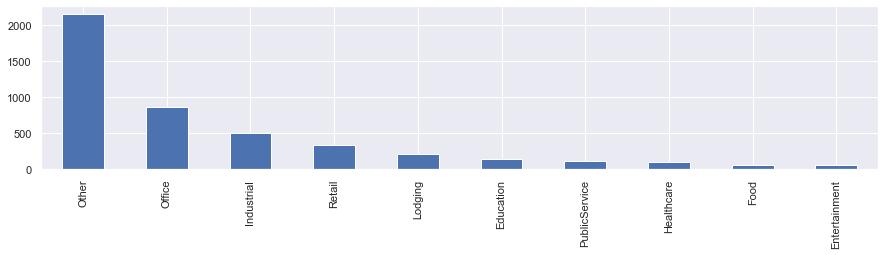

In [34]:
(((data['PrimaryPropertyType'].append(data['SecondLargestPropertyUseType'])).
  append(data['ThirdLargestPropertyUseType'])).append(data['LargestPropertyUseType'])).value_counts().plot.bar(figsize=(15,3))

## 2.4 Variables retenues

**Colonnes inutiles** :
- Address : On n'a pas besoin de connaître l'adresse du bâtiment
- ZipCode : On n'a pas besoin de connaître le code postal du bâtiment
- Neighborhood : On n'a pas besoin de connaître le quartier où le bâtiment est situé
- CouncilDistrictCode : On n'a pas besoin de connaître le code de conseil municipal
- City : Il y a une seule ville dans les données (Seattle), pas besoin de garder cette colonne
- State : La ville de Seattle est toujours dans le même Etat (Washington), donc pas besoin de garder cette donnée
- PropertyName : Pas besoin de savoir comment s'appellent les bâtiments.
- TaxParcelIdentificationNumber : On n'a pas besoin d'information fiscale
- ListOfAllPropertyUseTypes : Information disponible dans autres colonnes

In [35]:
feat_retenus = [
'BuildingType',
'PrimaryPropertyType',
'SecondLargestPropertyUseType',
'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType',
'ThirdLargestPropertyUseTypeGFA',
'NumberofFloors',
'NumberofBuildings',
'LargestPropertyUseType',
'LargestPropertyUseTypeGFA',
'ENERGYSTARScore',
# Variables créées
'NaturalGasRate',
'ElectricityRate',
'SteamUseRate',
'Age',
'Mean_GFA',
'CBD_distance_km',
'GFABuildingRate',
# Targets
'SiteEnergyUse(kBtu)',
'TotalGHGEmissions',
]

feat_retenus_num = [var for var in data[feat_retenus].select_dtypes(['int32', 'float64'])]
feat_retenus_cat = [var for var in data[feat_retenus].select_dtypes(['object','category'])]
C02_target = 'TotalGHGEmissions'
energy_target = 'SiteEnergyUseWN(kBtu)'

In [36]:
# KNN sur EnergyStarScore
data_no_nan = data[feat_retenus].drop(['SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA'],axis=1).dropna(subset=['ENERGYSTARScore']).dropna()
X = pd.get_dummies(data_no_nan.drop(['ENERGYSTARScore'],axis=1))
y = data_no_nan['ENERGYSTARScore']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2)
knn = neighbors.KNeighborsRegressor()

# Initialisation des paramètres
n_neighbors = np.arange(135, 150, 1)

params = {'n_neighbors' : n_neighbors}

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_ESS = GridSearchCV(knn, param_grid=params, cv=5)

# On entraine le modèle à partir des données d'entrainement
grid_ESS.fit(X_train, y_train)
grid_ESS.best_params_

{'n_neighbors': 138}

In [37]:
# KNN sur SecondLargestPropertyUseType
data_no_nan = data[feat_retenus].drop(['ENERGYSTARScore','ThirdLargestPropertyUseTypeGFA'],axis=1).dropna(subset=['SecondLargestPropertyUseTypeGFA']).dropna()
X = pd.get_dummies(data_no_nan.drop(['SecondLargestPropertyUseTypeGFA'],axis=1))
y = data_no_nan['SecondLargestPropertyUseTypeGFA']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2)
knn = neighbors.KNeighborsRegressor()

# Initialisation des paramètres
n_neighbors = np.arange(20, 55, 1)

params = {'n_neighbors' : n_neighbors}

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_SLPUT = GridSearchCV(knn, param_grid=params, cv=5)

# On entraine le modèle à partir des données d'entrainement
grid_SLPUT.fit(X_train, y_train)
grid_SLPUT.best_params_

{'n_neighbors': 41}

In [38]:
# KNN sur ThirdLargestPropertyUseType
data_no_nan = data[feat_retenus].drop(['ENERGYSTARScore','SecondLargestPropertyUseTypeGFA'],axis=1).dropna(subset=['ThirdLargestPropertyUseTypeGFA']).dropna()
X = pd.get_dummies(data_no_nan.drop(['ThirdLargestPropertyUseTypeGFA'],axis=1))
y = data_no_nan['ThirdLargestPropertyUseTypeGFA']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2)
knn = neighbors.KNeighborsRegressor()

# Initialisation des paramètres
n_neighbors = np.arange(20, 55, 1)

params = {'n_neighbors' : n_neighbors}

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_TLPUT = GridSearchCV(knn, param_grid=params, cv=5)

# On entraine le modèle à partir des données d'entrainement
grid_TLPUT.fit(X_train, y_train)
grid_TLPUT.best_params_

{'n_neighbors': 54}

In [39]:
duplicate_col = ['NumberofFloors',
                 'LargestPropertyUseTypeGFA',
                 'NumberofBuildings',
                 'NaturalGasRate',
                 'ElectricityRate',
                 'SteamUseRate',
                 'Age',
                 'Mean_GFA',
                 'CBD_distance_km',
                 'GFABuildingRate',
                 'SiteEnergyUse(kBtu)',
                 'TotalGHGEmissions'
                 ]

In [40]:
# Imputer les valeurs manquantes
imputer_ESS = KNNImputer(**grid_ESS.best_params_)
imputer_SLPUT = KNNImputer(**grid_SLPUT.best_params_)
imputer_TLPUT = KNNImputer(**grid_TLPUT.best_params_)

data_ESS = pd.DataFrame(imputer_ESS.fit_transform(data[feat_retenus_num]),columns=data[feat_retenus_num].columns).reset_index().drop(duplicate_col,axis=1).drop(["SecondLargestPropertyUseTypeGFA","ThirdLargestPropertyUseTypeGFA"],axis=1)
data_SLPUT = pd.DataFrame(imputer_SLPUT.fit_transform(data[feat_retenus_num]),columns=data[feat_retenus_num].columns).reset_index().drop(duplicate_col,axis=1).drop(["ENERGYSTARScore","ThirdLargestPropertyUseTypeGFA"],axis=1)
data_TLPUT = pd.DataFrame(imputer_TLPUT.fit_transform(data[feat_retenus_num]),columns=data[feat_retenus_num].columns).reset_index().drop(["SecondLargestPropertyUseTypeGFA","ENERGYSTARScore"],axis=1)

concatenor = [data_ESS,data_SLPUT,data_TLPUT,data[feat_retenus_cat].reset_index()]
data_clean = pd.concat(concatenor,axis=1).dropna().drop(['index'],axis=1)

In [41]:
#data_clean.columns.sort_values().tolist()

In [42]:
data_clean[feat_retenus_cat] = data_clean[feat_retenus_cat].astype('category')
data_clean[feat_retenus_num] = data_clean[feat_retenus_num].astype('float64')

<AxesSubplot:>

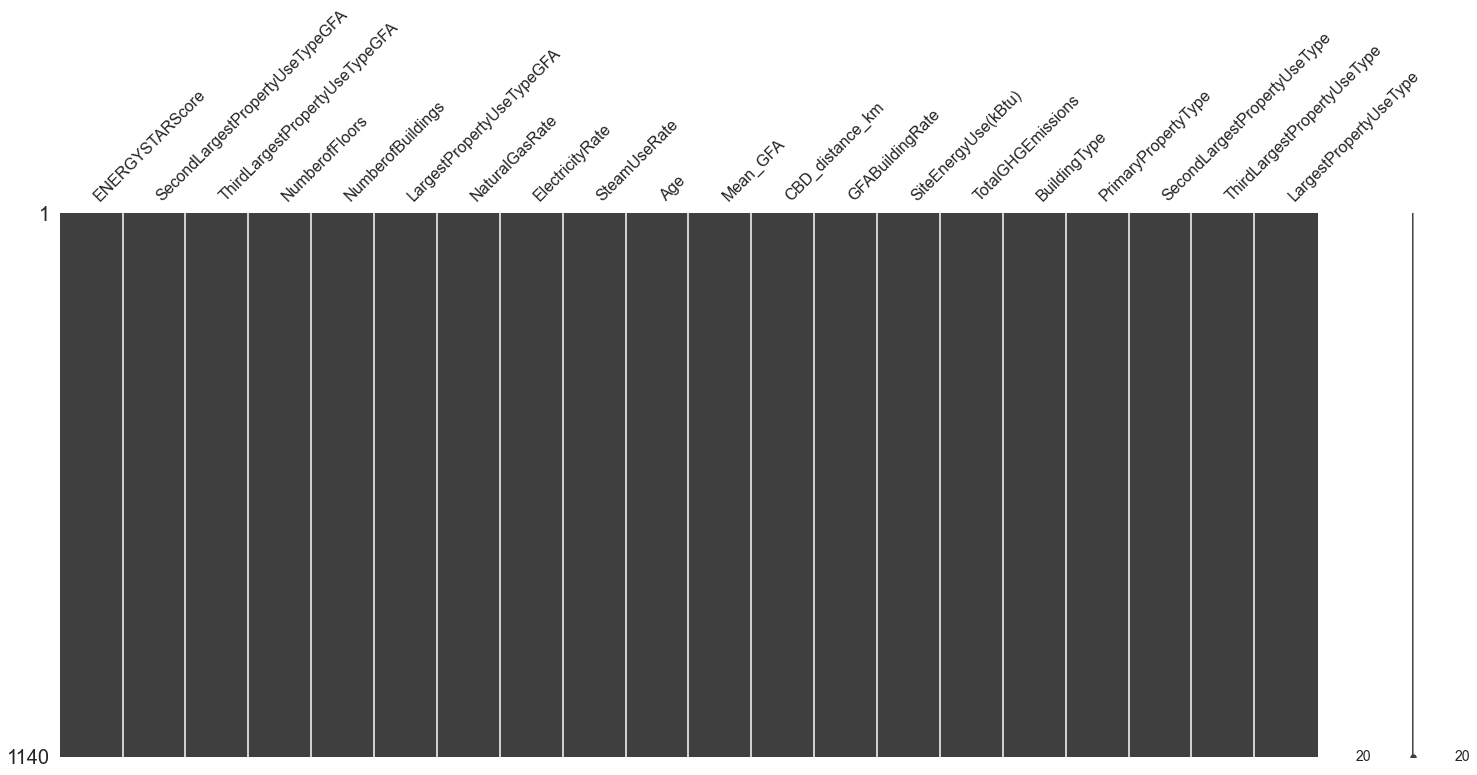

In [43]:
msno.matrix(data_clean)

# 3. Analyse exploratoire

## 3.1 Analyse univariée

In [44]:
data_clean.head()

,ENERGYSTARScore,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,NumberofFloors,NumberofBuildings,LargestPropertyUseTypeGFA,NaturalGasRate,ElectricityRate,SteamUseRate,Age,Mean_GFA,CBD_distance_km,GFABuildingRate,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,LargestPropertyUseType
0,60.000000,25148.829268,10259.394445,12.0,1.0,88434.0,17.66,54.61,27.73,89.0,7369.500000,0.481841,100.0,7226362.5,249.98,NonResidential,Lodging,Other,Other,Lodging
1,56.000000,24300.951220,10189.394445,10.0,1.0,61320.0,26.66,40.75,32.59,90.0,6132.000000,0.675452,100.0,6794584.0,286.43,NonResidential,Lodging,Other,Other,Lodging
2,27.000000,23482.000000,9080.722222,11.0,1.0,81352.0,51.18,48.82,0.00,90.0,7546.181818,0.694813,100.0,5758795.0,176.14,NonResidential,Lodging,Other,Other,Lodging
3,61.942029,22584.634146,9834.240741,8.0,1.0,102761.0,6.12,57.74,36.14,90.0,12845.125000,0.680426,100.0,6298131.5,221.51,NonResidential,Other,Other,Other,Entertainment
4,43.000000,76961.439024,14111.283334,15.0,1.0,163984.0,46.82,53.18,0.00,112.0,10932.266667,0.625880,100.0,13723820.0,392.16,NonResidential,Lodging,Other,Other,Lodging


In [45]:
# catégorielle
cat = []
# numérique
num = []

for col in data_clean.columns:
    if data_clean[col].dtype == 'object':
        cat.append(col)
    elif data_clean[col].dtype.name == 'category':
        cat.append(col)
    else:
        num.append(col)

property_use_types_columns = ['SecondLargestPropertyUseType',
                         'LargestPropertyUseType',
                         'ThirdLargestPropertyUseType',
                         'PrimaryPropertyType']

In [46]:
for column in data[property_use_types_columns].columns:
    print(data[column].value_counts())
    print('\n')

Other            817
Office           148
Retail            74
Food              31
Industrial        26
Entertainment     16
Education          8
Healthcare         8
Lodging            7
PublicService      5
Name: SecondLargestPropertyUseType, dtype: int64


Office           357
Industrial       242
Retail           127
Lodging          101
Other             90
Education         69
PublicService     58
Healthcare        48
Entertainment     38
Food              10
Name: LargestPropertyUseType, dtype: int64


Other            1023
Retail             32
Office             31
Food               17
Industrial         13
Lodging             9
Entertainment       8
Healthcare          4
Education           3
Name: ThirdLargestPropertyUseType, dtype: int64


Office           334
Industrial       226
Other            222
Retail           101
Lodging           90
Education         63
PublicService     56
Healthcare        39
Food               9
Name: PrimaryPropertyType, dtype: int64




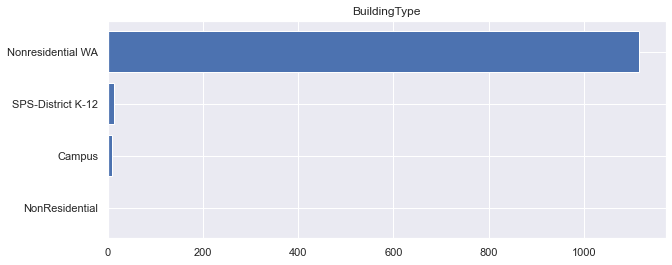

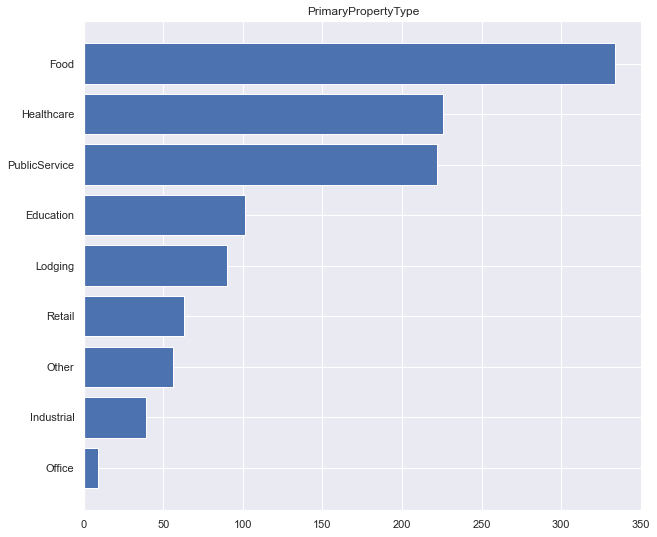

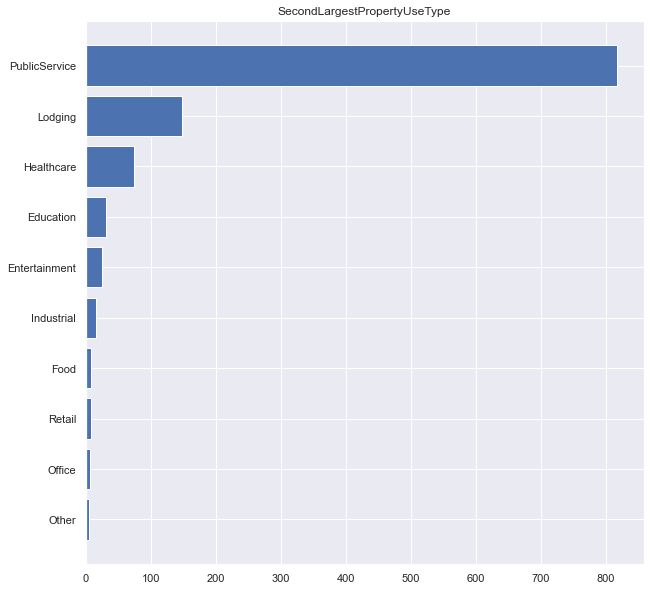

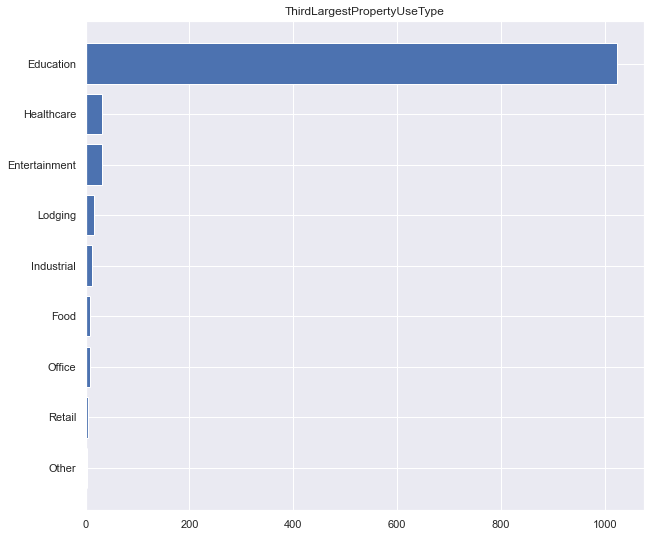

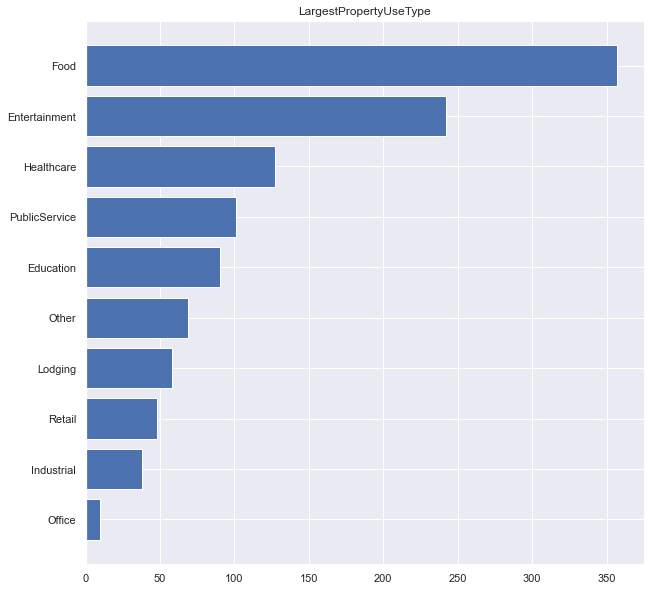

In [47]:
# Variables categorielles
sns.set()
for col in cat:
    df_viz = pd.DataFrame(data_clean[col].value_counts())
    fig, ax = plt.subplots(figsize=(10,len(df_viz.index)))
    plt.title(col)
    ax.barh(df_viz.index, df_viz[col].sort_values())

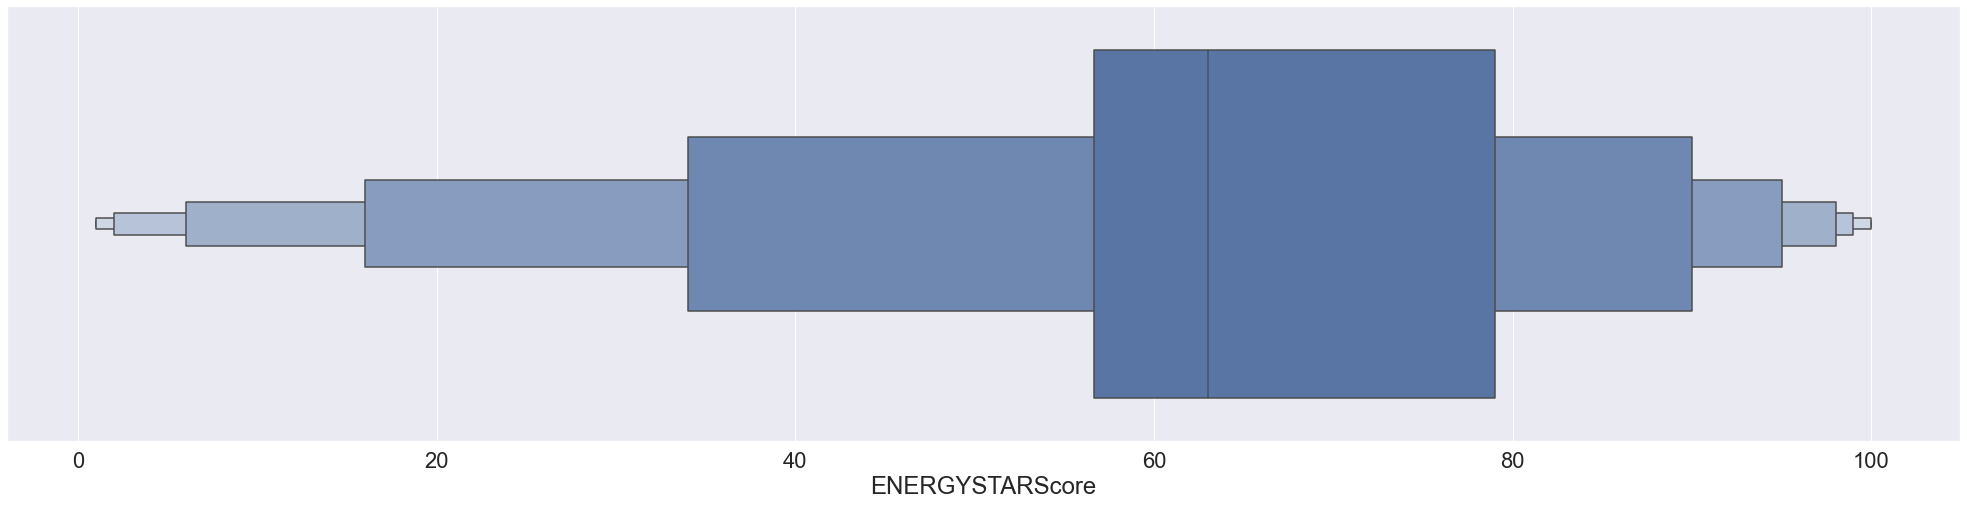

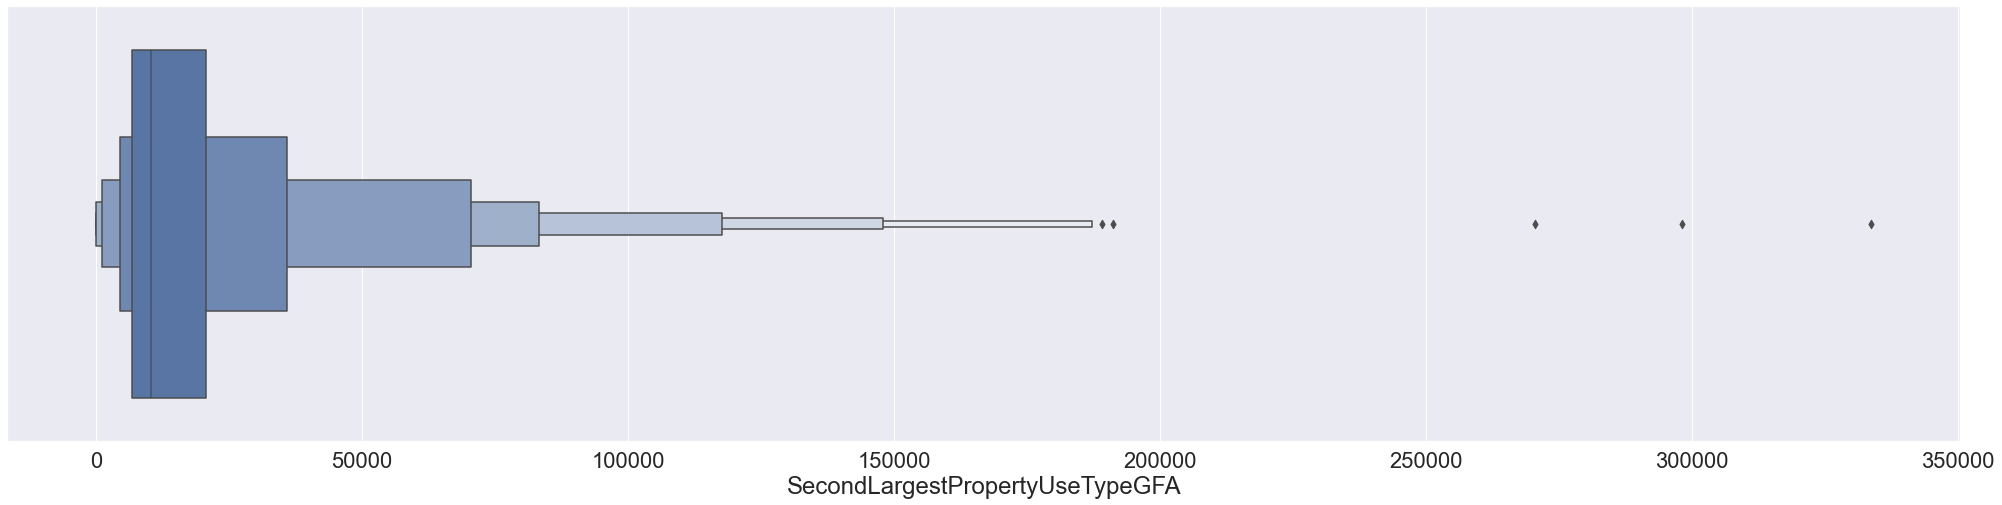

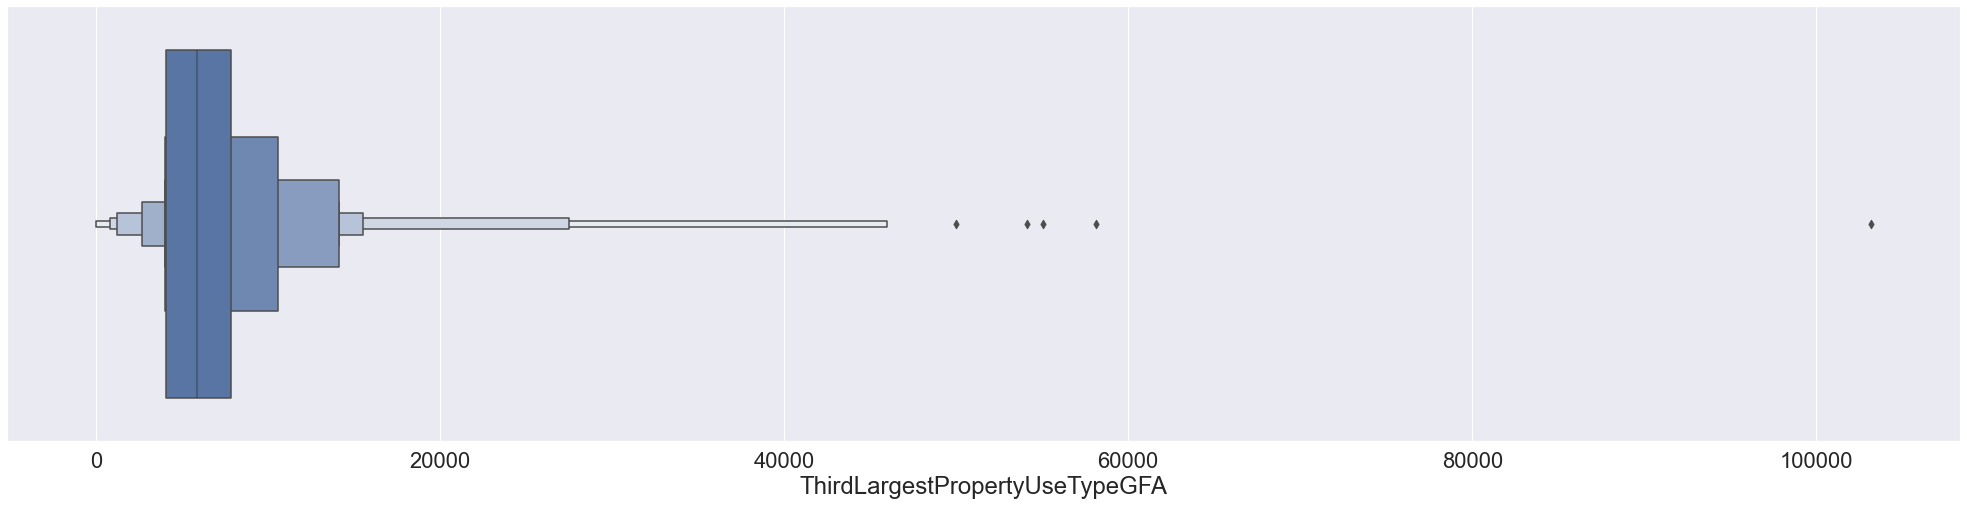

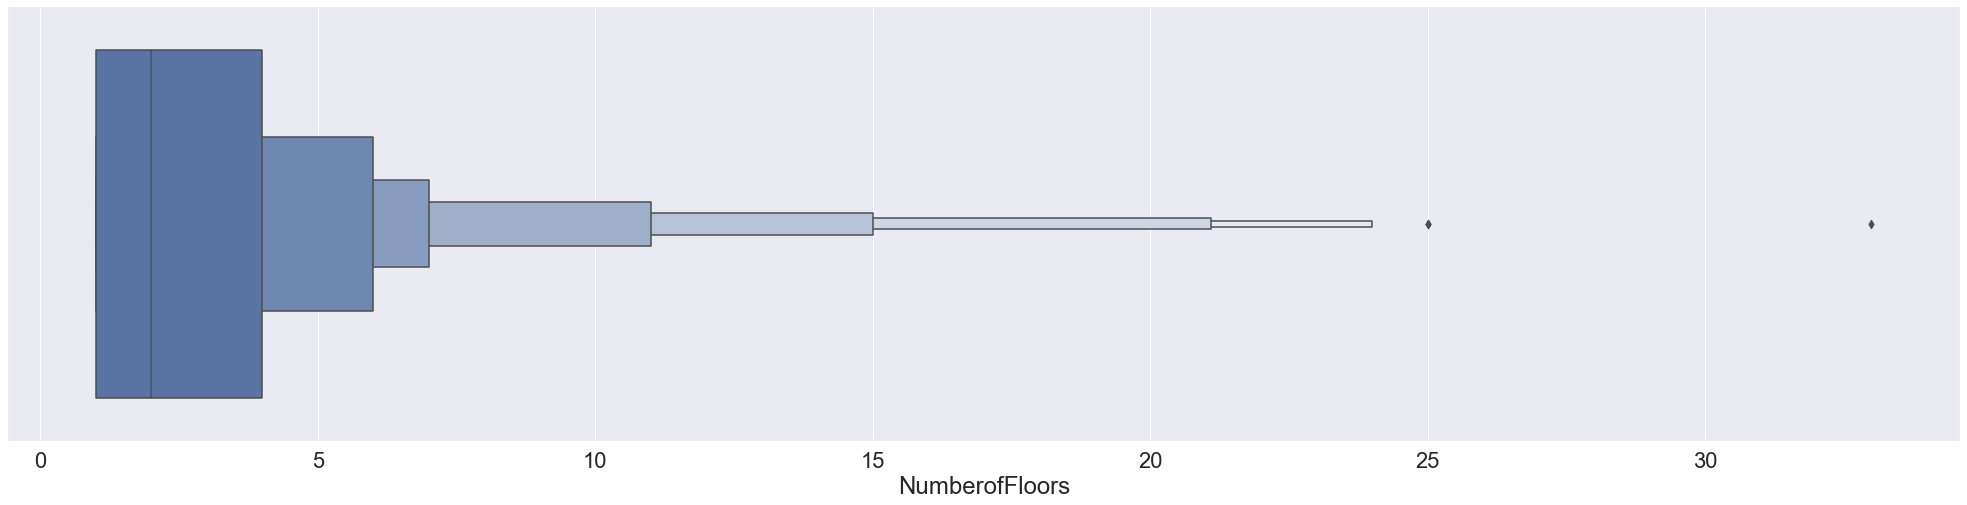

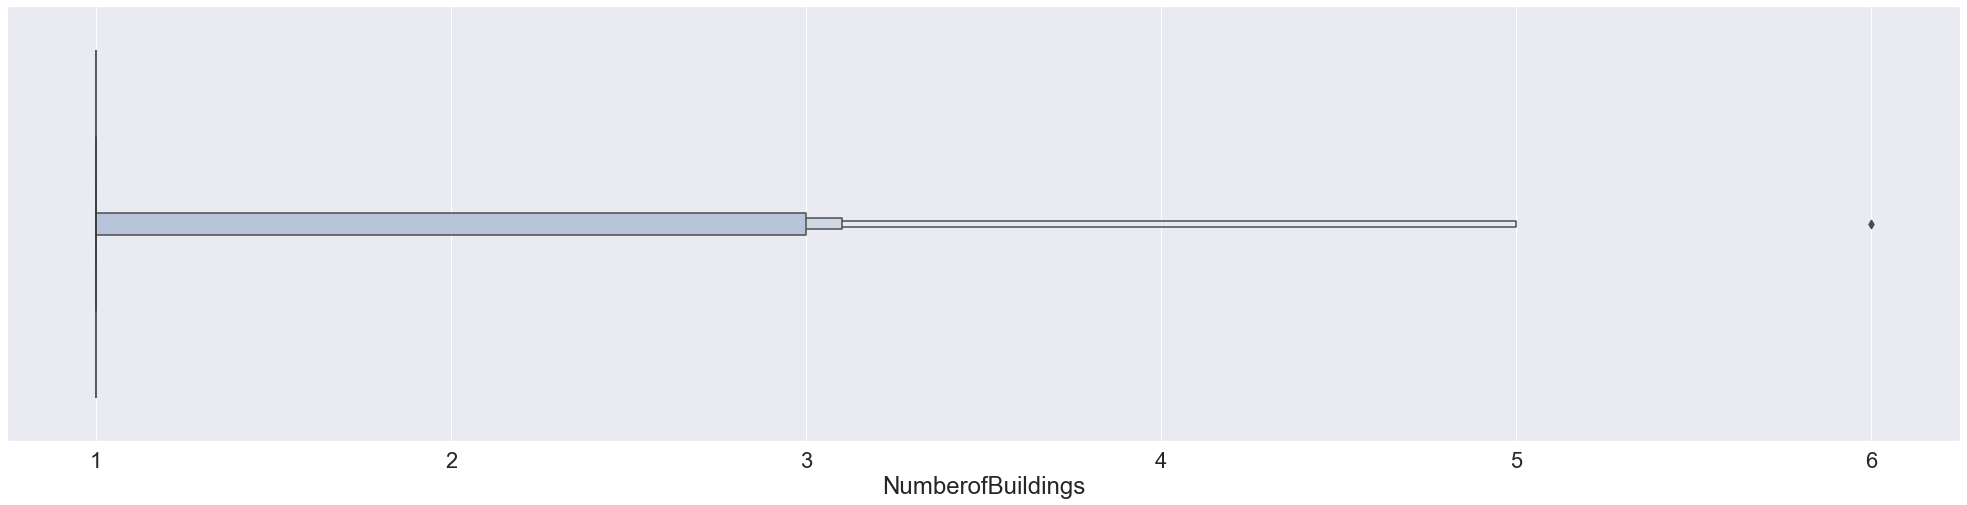

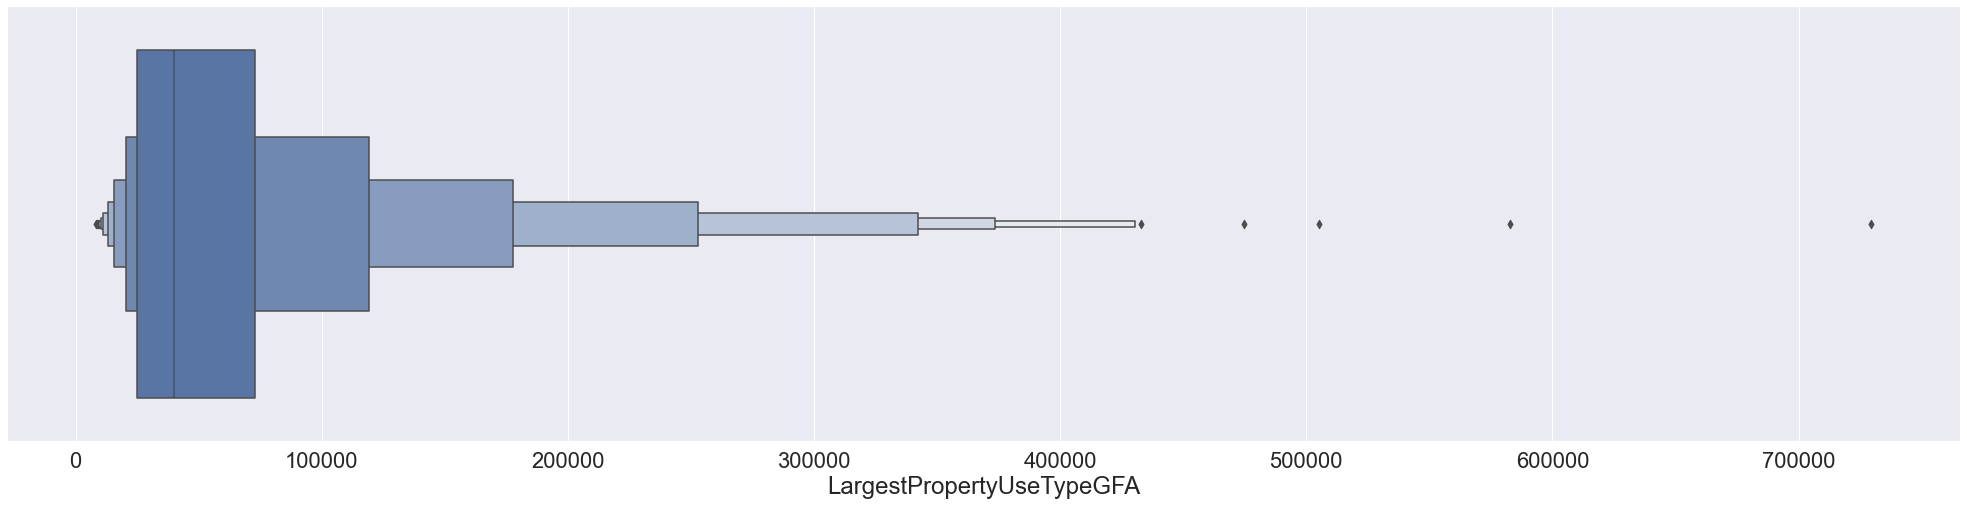

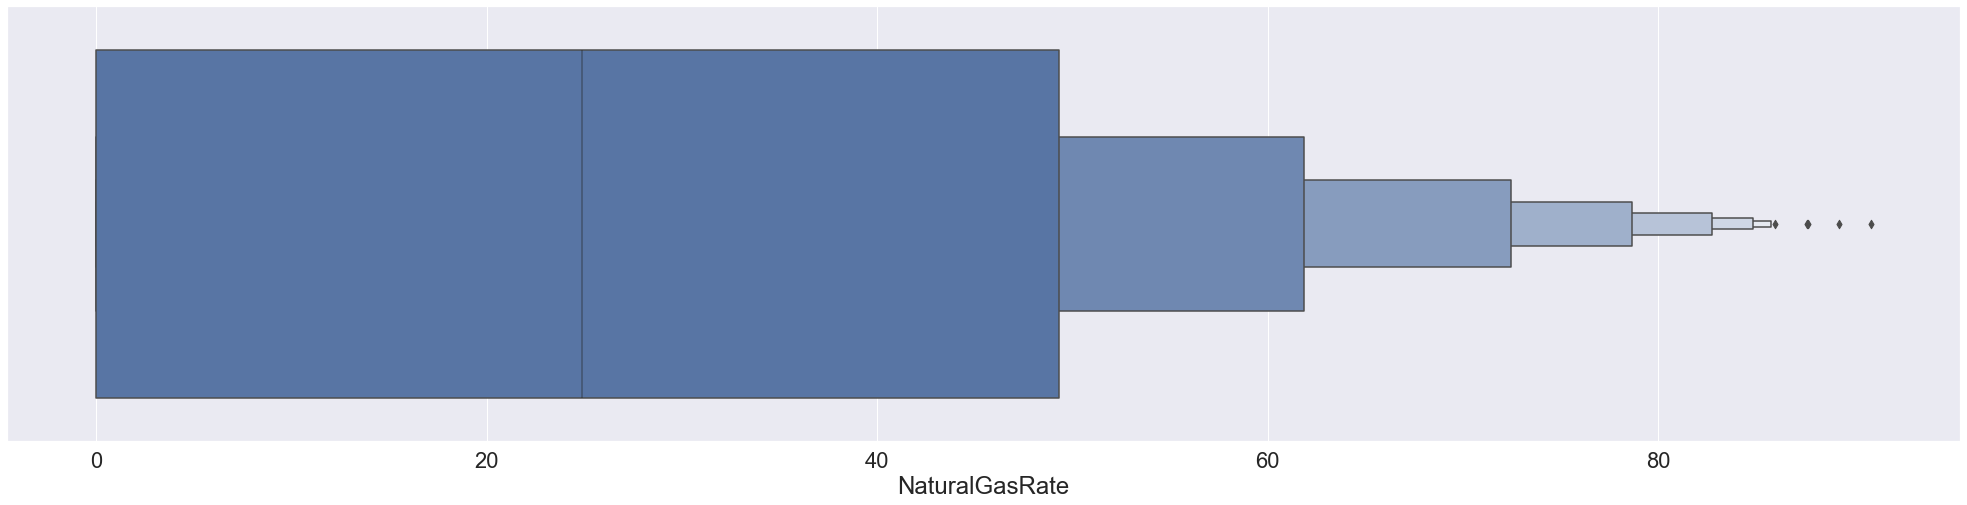

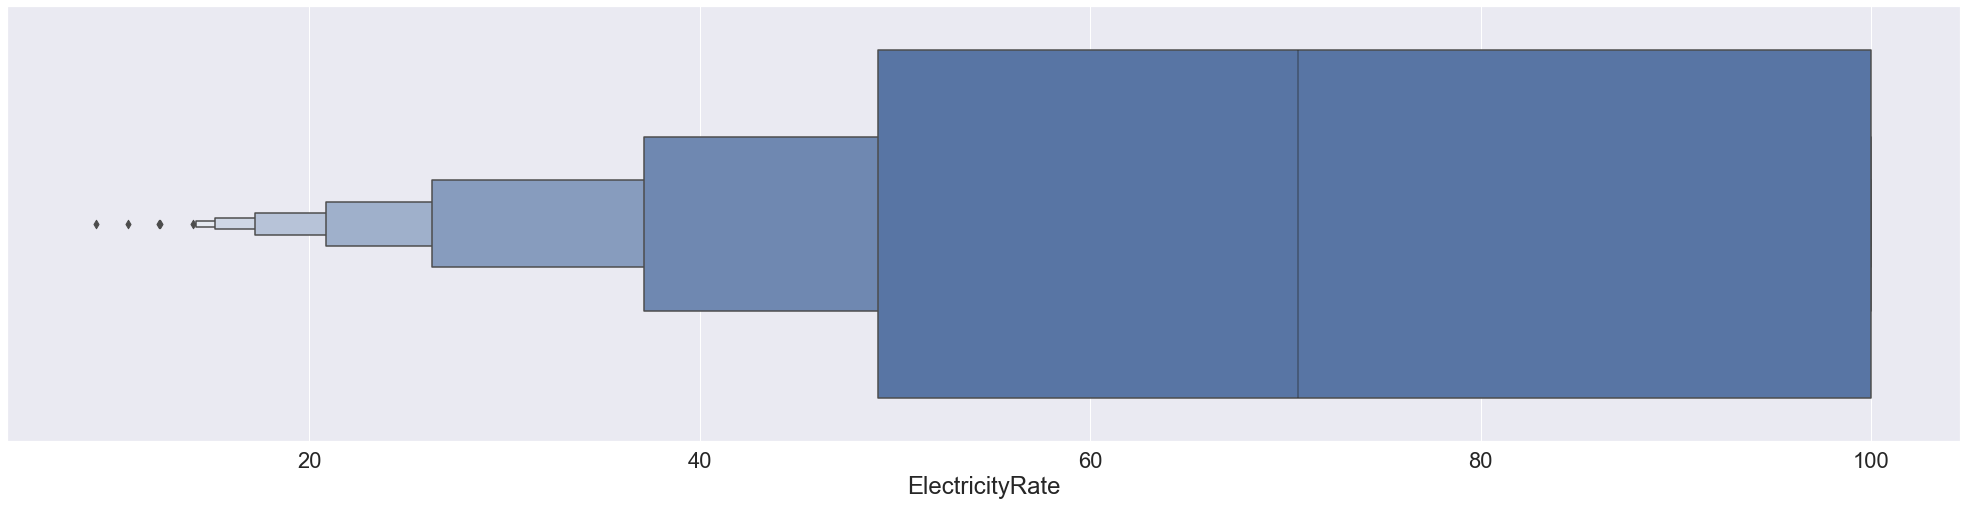

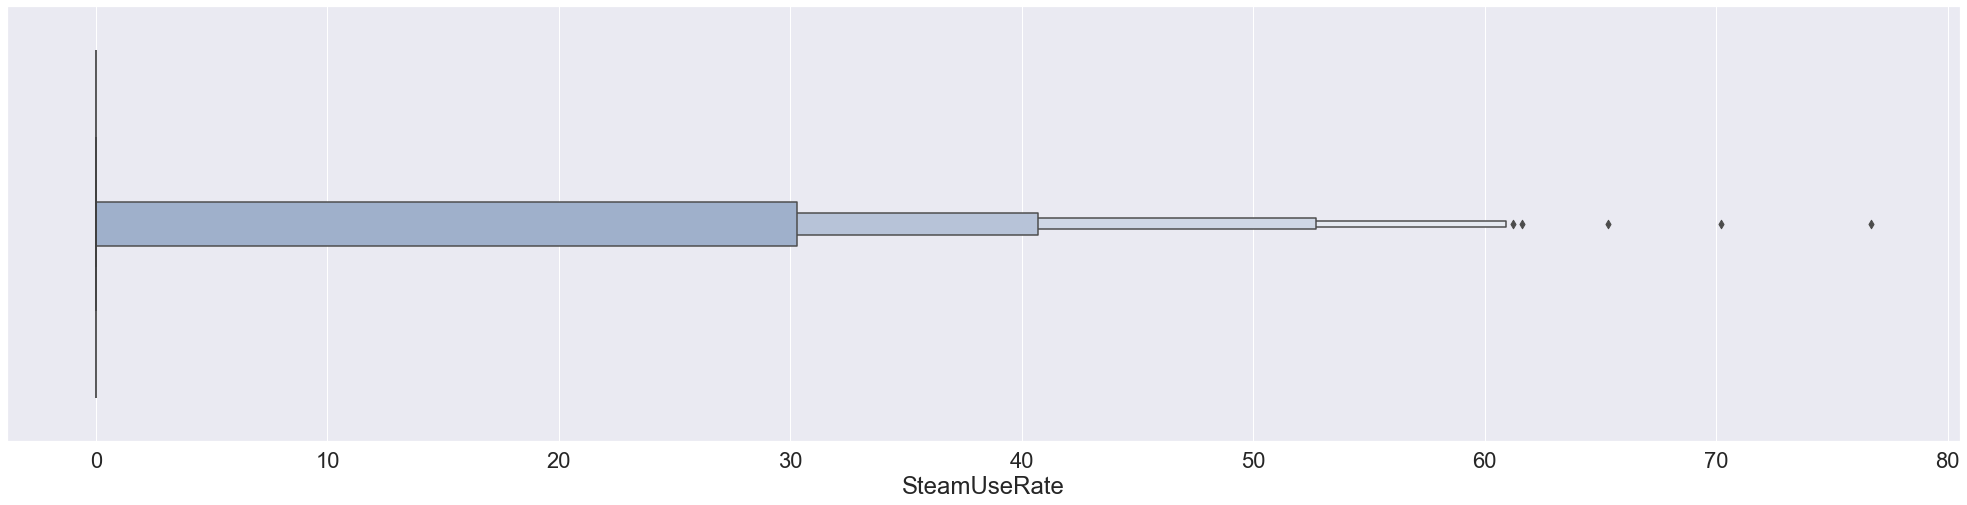

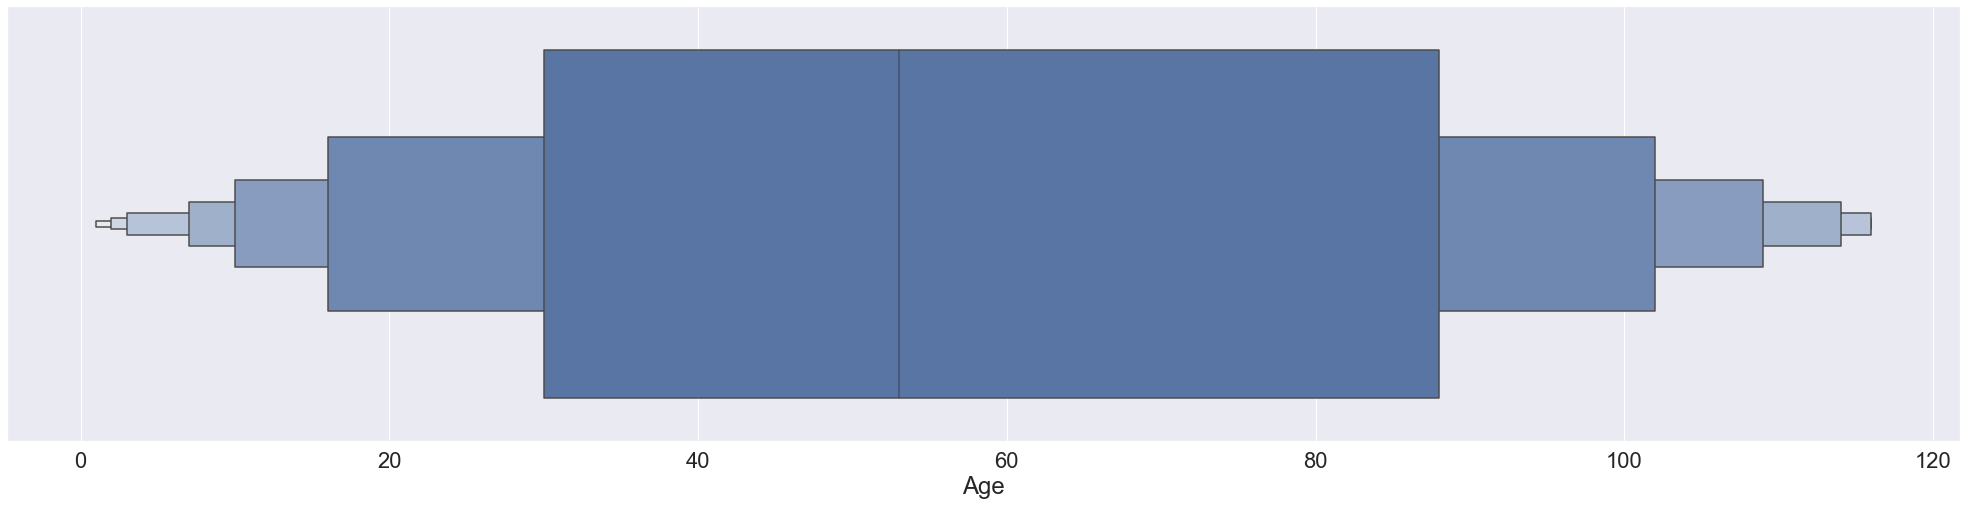

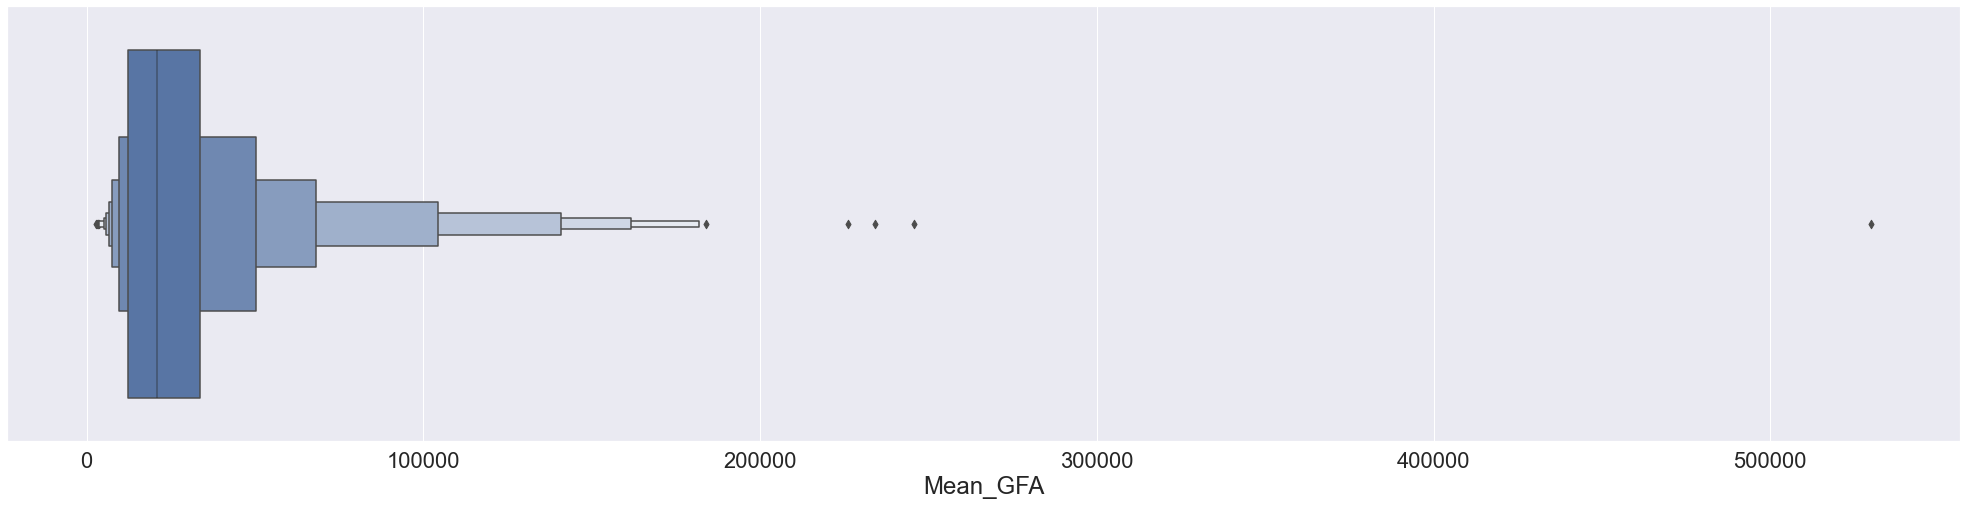

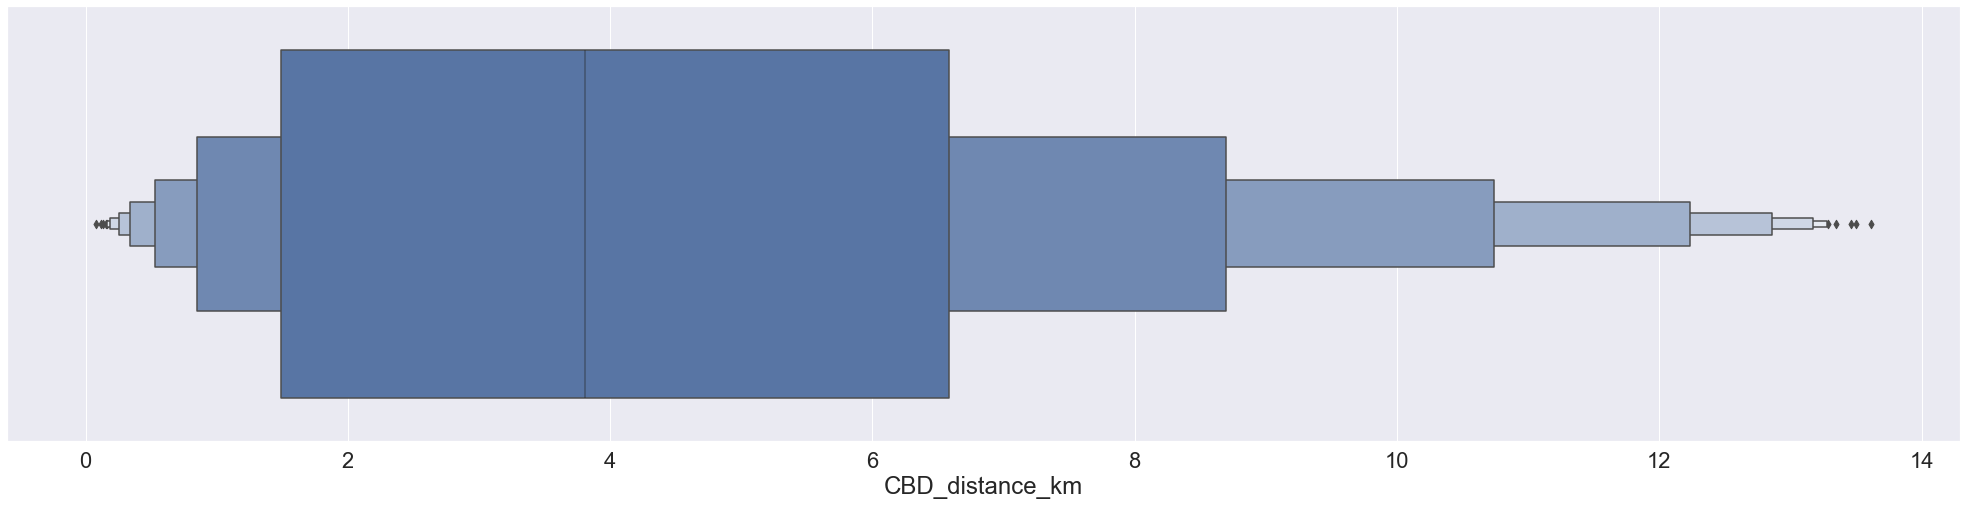

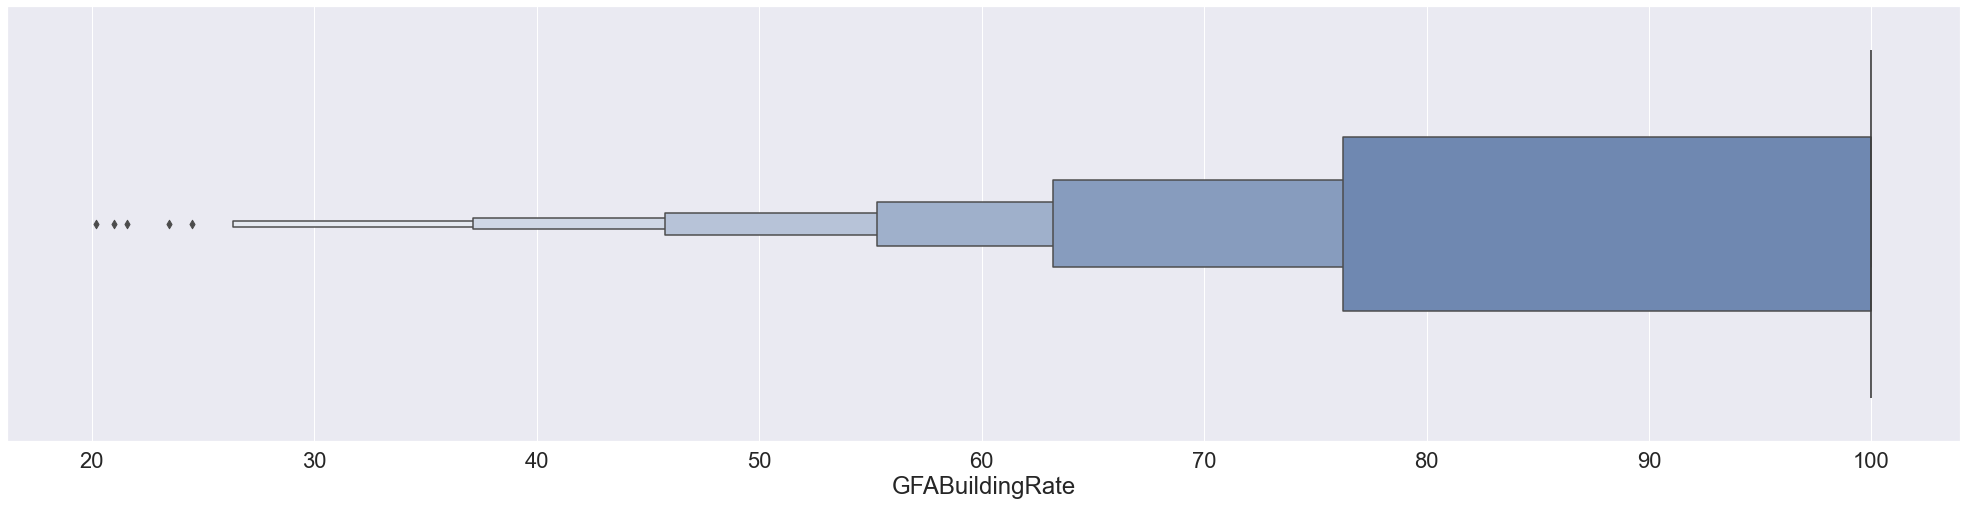

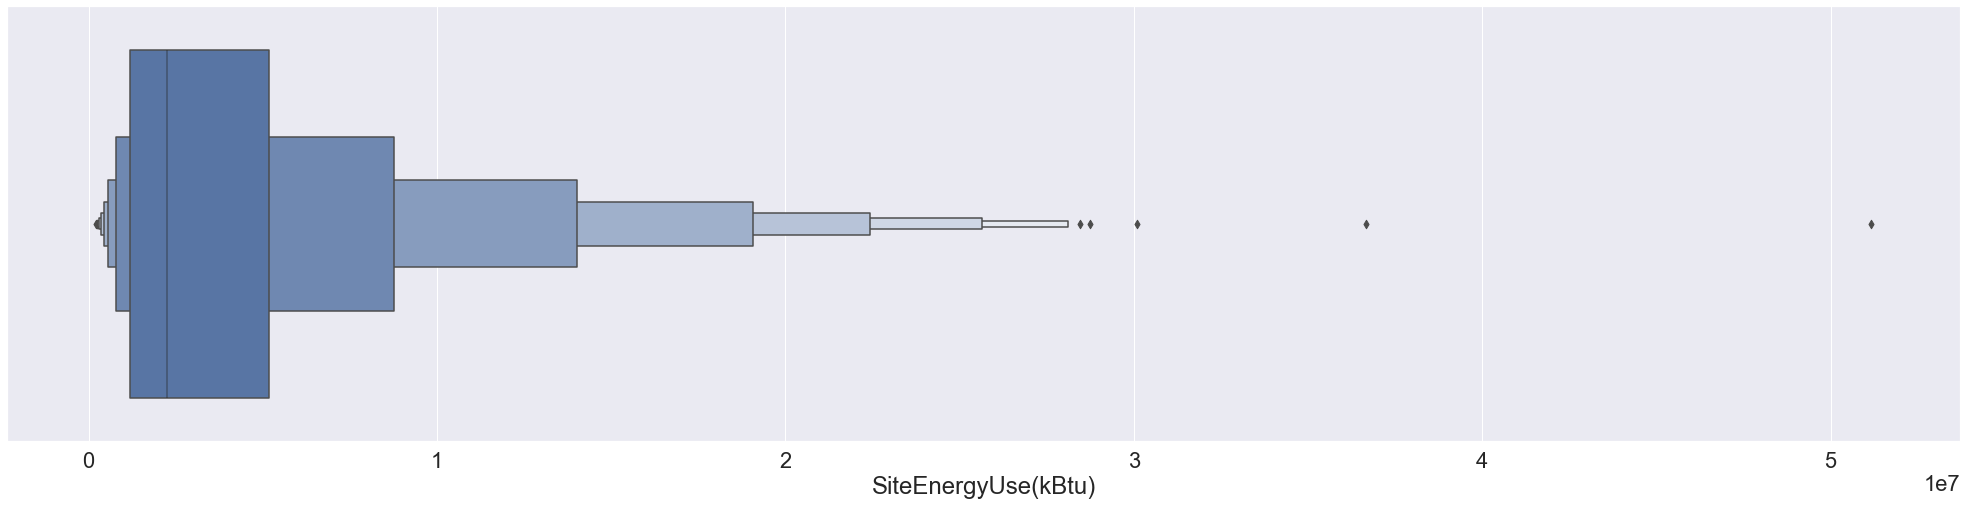

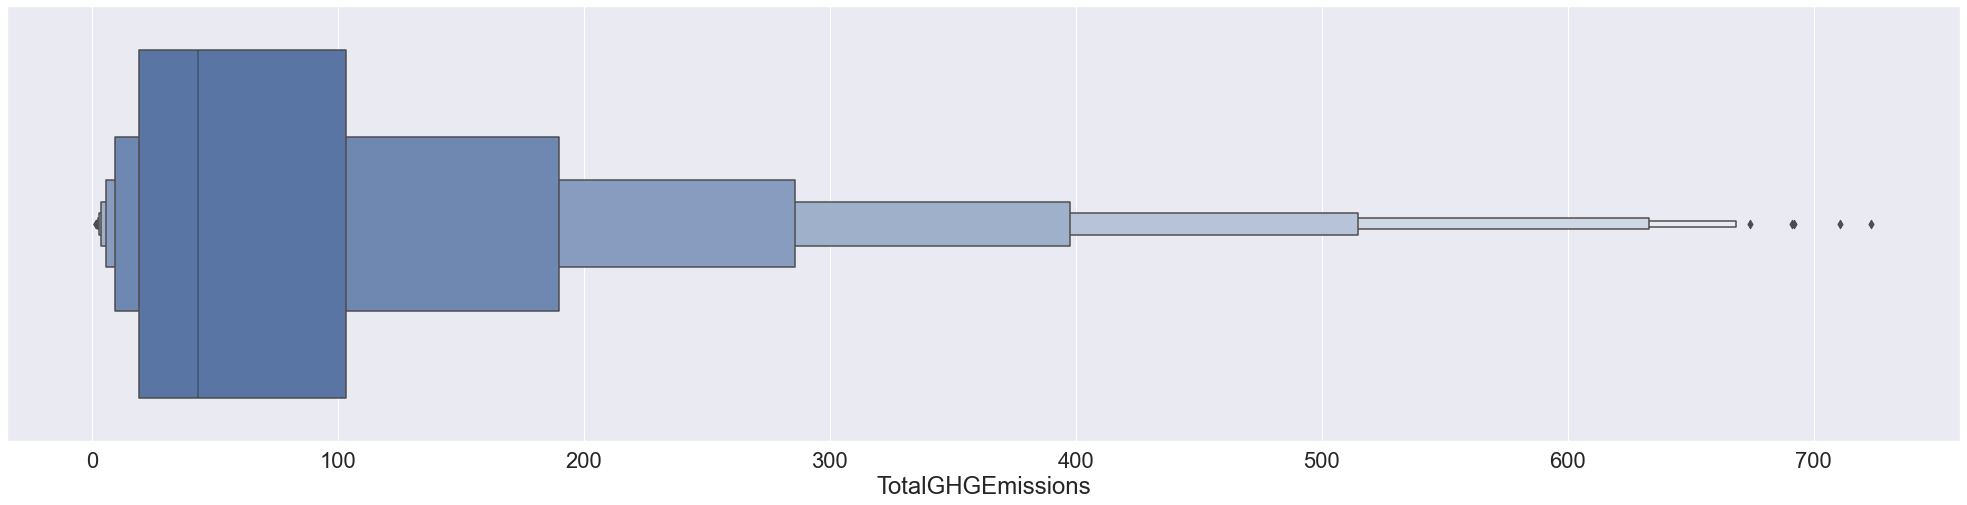

In [48]:
# Variables numériques
sns.set(font_scale=2)
for col in num:
    plt.figure(figsize = (35,8))
    sns.boxenplot(data_clean[col])
    plt.xlabel(col)
    plt.show()
sns.set(font_scale=1)

## 3.2 Analyse bivariée

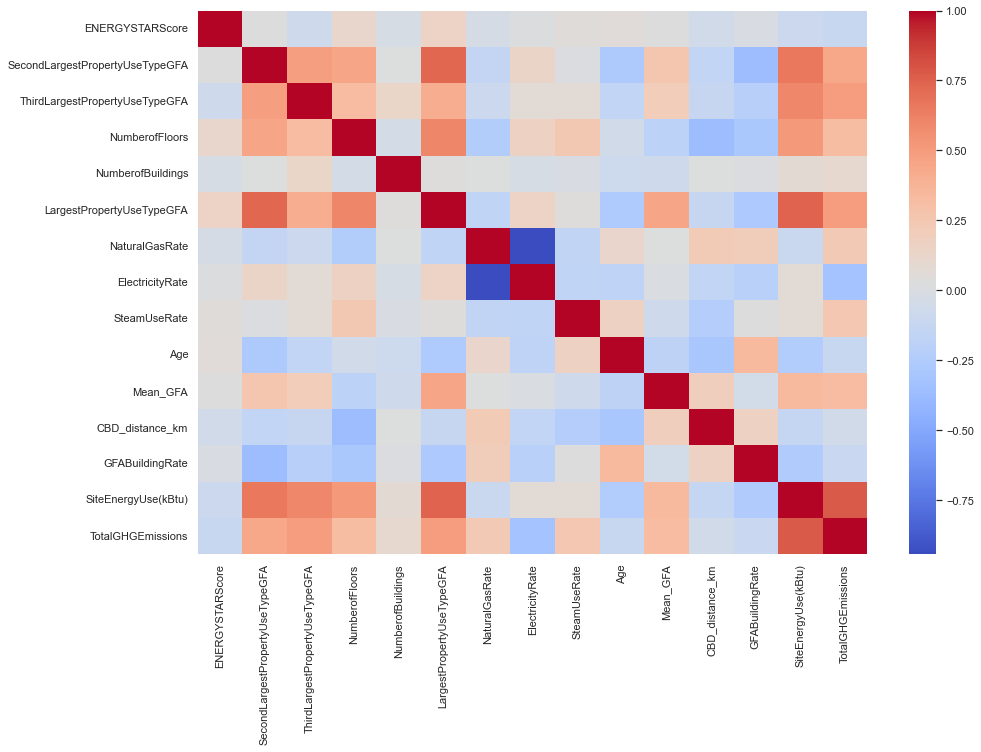

In [49]:
plt.figure(figsize=(15, 10))
sns.heatmap(data_clean.corr(),cmap='coolwarm');

<AxesSubplot:>

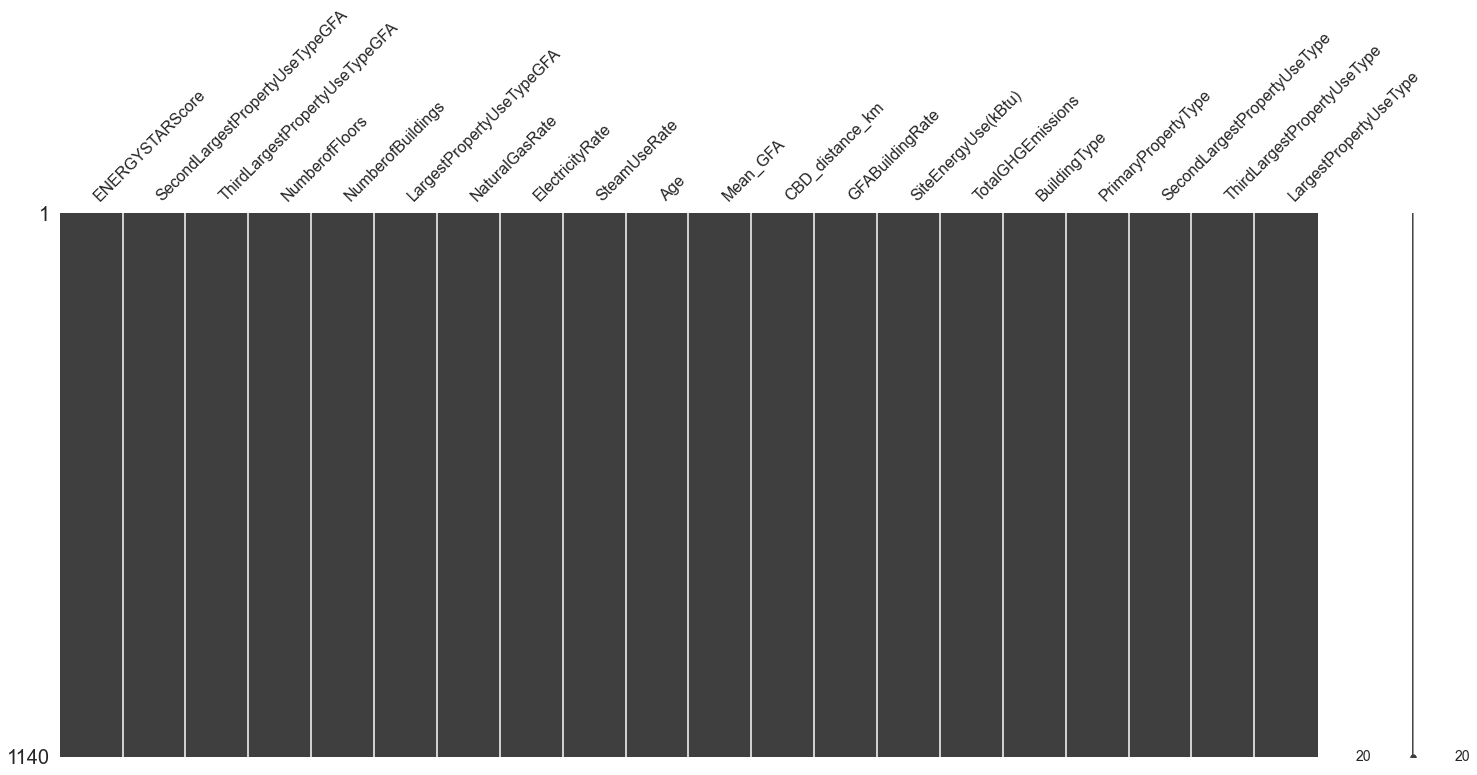

In [50]:
msno.matrix(data_clean)

In [51]:
data_clean.to_csv("cleaned_dataset.csv")